In [1]:
# =================================================================================
# 1-1. Library Import 
# =================================================================================
import os
import copy
import glob
import random
import time
import io
import contextlib
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
# =================================================================================
# 1-2. CONFIG (experiment setup for MHEALTH)
# =================================================================================
CONFIG = {
    # ---------------------------
    # Reproducibility / ID
    # ---------------------------
    "seed": 42,
    "dataset_name": "MHEALTH",

    # ---------------------------
    # Data / Windowing
    # ---------------------------
    # MHEALTH raw 로그(.log)들이 들어있는 상위 폴더
    "data_dir": r"C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET",

    # MHEALTH 슬라이딩 윈도우 설정
    # (250 samples per window, 125 stride)  <- 이건 문헌에서 자주 쓰는 셋팅이라 baseline처럼 둘 거야
    "window_size": 128,
    "step_size": 64,

    # train/val/test split 방식:
    # - subject-wise 분할 (각 subject 기준으로 60/20/20 나눌 예정)
    # (class 비율은 안 맞춰주고, subject generalization 관점 유지)
    "subject_split_train_ratio": 0.6,
    "subject_split_val_ratio": 0.2,
    # 나머지 0.2는 test

    "batch_size": 128,

    # ---------------------------
    # Training
    # ---------------------------
    "epochs": 100,
    "learning_rate": 5e-4,
    "weight_decay": 1e-4,

    "contrast_weight": 0.25,     # total_loss = CE + contrast_weight * contrast_loss
    "temperature": 0.05,         # contrastive prototype loss temperature

    "scheduler_type": "cosine",  # 고정 (CosineAnnealingLR)
    "scheduler_T_max": 100,      # should match epochs

    # ---------------------------
    # Model architecture
    # ---------------------------
    # MHEALTH 채널: 23채널 (가슴/발목/팔 가속도+자이로+자력 + ECG 등)
    "in_channels": 23,

    # 시퀀스 길이: window_size 그대로 들어가므로 128
    "seq_len": 128,

    # MHEALTH 라벨: 1~12 동작, 0은 "null/기타"라서 학습에서 제외.
    # => 그래서 실제 학습 클래스는 12개.
    "n_classes": 12,
    "n_prototypes": 12,  # prototype per class (1:1)

    "embed_dim": 64,     # Conv1d embed dim (우리는 이걸 고정해서 계속 씀)
    "reduced_dim": 32,   # only used if use_dim_reduction=True
    "use_dim_reduction": False,

    "n_heads": 8,
    "dropout": 0.1,

    # Conv1d kernel + CBAM temporal kernel
    "kernel_size": 7,

    # ---------------------------
    # Feature toggles / Ablations
    # ---------------------------
    "use_cbam": True,
    "use_crossformer": True,
    "use_contrast": True,    # prototype contrast term on during training

    # ---------------------------
    # Logging / Debug convenience
    # ---------------------------
    "print_every": 25,
    "do_tsne": True,
    "profile_model": True,
}


def pretty_print_config(cfg: dict):
    print("=" * 80)
    print("EXPERIMENT CONFIG")
    print("-" * 80)
    max_k = max(len(k) for k in cfg.keys())
    for k in sorted(cfg.keys()):
        print(f"{k.ljust(max_k)} : {cfg[k]}")
    print("=" * 80)

In [3]:
# =================================================================================
# 1-3. Reproducibility helpers
# =================================================================================

def seed_everything(seed: int = 42):
    """
    Fix random seeds for reproducibility across random, numpy, torch (cpu & cuda).
    Also configures CuDNN for deterministic behavior.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # cudnn deterministic mode: reproducible but may be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """
    To make DataLoader workers deterministic.
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
# =================================================================================
# 1-4. Dataset: MHEALTH (23-channel version)
# =================================================================================
def _load_single_mhealth_log(path: str, feature_cols: list[str]):
    """
    하나의 mHealth_subjectXX.log 파일을 로드해서 DataFrame으로 반환.
    파일은 탭(\t)으로 구분된 24개의 컬럼:
        23개 센서 채널 + 마지막 1개 activity label
    여기서는 subject ID는 따로 붙이지 않고,
    단순히 시계열만 이어붙일 목적이라 subject 열은 만들지 않는다.
    (=> 기존 코드와 동일하게 subject 구분 없이 concat)
    """
    # names=[23개 피처 + 'label'] 로 읽는다
    df = pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=feature_cols + ["label"],
    )
    return df


def load_mhealth_dataframe(data_dir: str):
    """
    data_dir 안의 mHealth_subject*.log 전부 읽어서 하나의 DataFrame으로 concat.
    (기존 코드와 동일하게 subject별 경계 정보는 사용하지 않고, 그냥 이어붙임)
    """
    feature_cols = [
        "acc_chest_x", "acc_chest_y", "acc_chest_z",
        "ecg_1", "ecg_2",
        "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",
        "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",
        "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",
        "acc_arm_x", "acc_arm_y", "acc_arm_z",
        "gyro_arm_x", "gyro_arm_y", "gyro_arm_z",
        "mag_arm_x", "mag_arm_y", "mag_arm_z",
    ]  # 총 23 channels

    log_files = glob.glob(os.path.join(data_dir, "mHealth_subject*.log"))
    print(f"Found {len(log_files)} log files in {data_dir}")

    dfs = []
    for fp in log_files:
        df_i = _load_single_mhealth_log(fp, feature_cols)
        dfs.append(df_i)

    if not dfs:
        raise RuntimeError(f"No mHealth_subject*.log files found under {data_dir}")

    full_df = pd.concat(dfs, ignore_index=True)

    # Null 클래스(label==0)는 제외 (기존 코드 동일)
    full_df = full_df[full_df["label"] != 0].copy()

    # 원래 라벨 1~12 → 0~11 로 shift
    full_df.loc[:, "label"] = full_df["label"] - 1

    return full_df, feature_cols


def create_mhealth_windows(
    df: pd.DataFrame,
    feature_cols: list[str],
    window_size: int,
    step_size: int,
):
    """
    전체 시계열을 (window_size, step_size)로 슬라이딩하면서 윈도우 생성.
    - 윈도우 라벨 = 그 윈도우 마지막 프레임의 라벨 (end-1)
    - 윈도우 내에 여러 클래스가 섞여 있어도 상관없음
    - 이미 label==0 (Null)은 load 단계에서 제거했으므로 여기선 신경 안 씀

    반환:
        X_np : (N, C, T) float32  ← (채널, 시간)
        y_np : (N,) int64         ← 0~11 로 이미 shift된 라벨
    """
    data_arr = df[feature_cols].to_numpy(dtype=np.float32)  # (L, 23)
    labels_arr = df["label"].to_numpy(dtype=np.int64)       # (L,)

    L = data_arr.shape[0]

    X_list = []
    y_list = []

    start = 0
    while start + window_size <= L:
        end = start + window_size

        window_x = data_arr[start:end]        # (T, C)
        window_label = labels_arr[end - 1]    # 마지막 타임스텝 라벨

        # (T, C) -> (C, T) 로 바꿔서 모델 입력 형태랑 맞춤
        window_x_ct = np.transpose(window_x, (1, 0))  # (23, window_size)

        X_list.append(window_x_ct)
        y_list.append(int(window_label))

        start += step_size

    if not X_list:
        raise RuntimeError("No windows created. Check window_size / step_size / dataset length.")

    X_np = np.stack(X_list, axis=0).astype(np.float32)  # (N, 23, window_size)
    y_np = np.array(y_list, dtype=np.int64)             # (N,)

    return X_np, y_np


class MHEALTHDataset(Dataset):
    """
    MHEALTH Dataset wrapper
    - 로직은 기존 버전 그대로:
      1) 모든 subject의 로그를 읽어 하나의 긴 시계열로 합침
      2) label==0(Null) 은 제거
      3) 라벨을 0부터 시작하도록 shift
      4) 전체 시계열을 슬라이딩 윈도우
         - 윈도우 라벨 = 마지막 프레임 라벨
      5) 반환 shape: (C, T)
    """
    def __init__(self, data_dir: str, window_size: int = 128, step_size: int = 64):
        super().__init__()

        # 1) 로그 로드 & 전처리
        full_df, feature_cols = load_mhealth_dataframe(data_dir)

        # 2) 슬라이딩 윈도우 생성
        X, y = create_mhealth_windows(
            df=full_df,
            feature_cols=feature_cols,
            window_size=window_size,
            step_size=step_size,
        )

        # 보관
        self.X = X  # (N, C, T), float32
        self.y = y  # (N,), int64

        # 라벨 이름 (0~11 인덱스 기준)
        # 원래 mHealth 라벨 정의에서 1~12 이고, 우리가 -1 해서 0~11 됨.
        self.label_names = [
            "Standing still",            # 1 -> 0
            "Sitting and relaxing",      # 2 -> 1
            "Lying down",                # 3 -> 2
            "Walking",                   # 4 -> 3
            "Climbing stairs",           # 5 -> 4
            "Waist bends forward",       # 6 -> 5
            "Frontal elevation of arms", # 7 -> 6
            "Knees bending",             # 8 -> 7
            "Cycling",                   # 9 -> 8
            "Jogging",                   # 10 -> 9
            "Running",                   # 11 -> 10
            "Jump front & back",         # 12 -> 11
        ]

        print("=" * 80)
        print("Loaded MHEALTH dataset")
        print(f"  X shape : {self.X.shape}  (N, C, T)")
        print(f"  y shape : {self.y.shape}  (N,)")
        print(f"  Classes : {len(self.label_names)}")
        print("=" * 80)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        """
        Returns:
            x_i: torch.FloatTensor, shape (C,T)
            y_i: torch.LongTensor scalar
        """
        x_i = torch.from_numpy(self.X[idx]).float()
        y_i = torch.tensor(self.y[idx], dtype=torch.long)
        return x_i, y_i


In [5]:
# =================================================================================
# 2. CBAM (1D 버전)
# =================================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)
        max_out = self.fc(max_out)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)
        return x * scale


class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)

        out = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        out = self.conv(out)                        # (B, 1, T)
        out = self.sigmoid(out)
        return x * out


class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        # x : (B, C, T)
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [6]:
# =================================================================================
# 3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    각 클래스의 prototype과 feature를 InfoNCE 스타일로 밀어붙이는 loss
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = temperature

    def forward(
        self,
        features: torch.Tensor,    # (B, D)
        prototypes: torch.Tensor,  # (N_class, D)
        labels: torch.Tensor       # (B,)
    ):
        """
        Returns:
            scalar contrastive loss (tensor)
        """
        # L2 normalize
        features = F.normalize(features, dim=1, eps=1e-6)
        prototypes = F.normalize(prototypes, dim=1, eps=1e-6)

        # cosine similarity -> logits
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        return F.cross_entropy(logits, labels)

In [7]:
# =================================================================================
# 4. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    """
    Token sequence ↔ class prototypes 간 cross-attention + self-attention 블록.

    흐름:
      1) (선택) Cross-Attention
         - query: 시퀀스 토큰 x (B, T, C)
         - key/value: learnable prototypes (P, C)
         - 각 토큰이 어떤 prototype(=행동 클래스)랑 강하게 연결되는지 학습
      2) Self-Attention
         - 토큰들끼리 상호참조
      3) MLP
      4) (옵션) contrast를 위한 샘플 표현(proto_features) 뽑기

    Args:
        dim                : token embedding dim (C)
        n_prototypes       : prototype 개수 (보통 클래스 수와 동일)
        n_heads            : multi-head attention head 수
        mlp_ratio          : FFN hidden dim 배수 (hidden_dim = dim * mlp_ratio)
        dropout            : dropout rate
        initial_prototypes : (n_prototypes, dim) 텐서. 제공되면 그 값으로 prototype init,
                             없으면 Xavier Uniform으로 초기화
    """
    def __init__(self,
                 dim: int,
                 n_prototypes: int = 6,
                 n_heads: int = 4,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1,
                 initial_prototypes: torch.Tensor = None):
        super().__init__()

        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # -------------------------------------------------
        # Learnable prototypes (P, C)
        # -------------------------------------------------
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))

        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, (
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} "
                f"vs self.prototypes {self.prototypes.shape}"
            )
            self.prototypes.data.copy_(initial_prototypes)
            print("Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print("Prototypes initialized with Xavier Uniform.")

        # -------------------------------------------------
        # Cross-Attention: tokens Q  vs  prototypes K,V
        # -------------------------------------------------
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )

        # -------------------------------------------------
        # Self-Attention on tokens
        # -------------------------------------------------
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )

        # -------------------------------------------------
        # FFN (MLP with residual)
        # -------------------------------------------------
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

        # contrast용 sample-level feature projection
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(
        self,
        x: torch.Tensor,
        return_proto_features: bool = False,
        skip_cross_attention: bool = False
    ):
        """
        Args:
            x : (B, T, C=dim)
            return_proto_features : True면 contrastive loss용 feature도 같이 리턴
            skip_cross_attention  : True면 cross-attn을 건너뛰고 self-attn만 수행
                                    (프로토타입 초기화할 때 평균 특징 뽑는 용도)

        Returns:
            if return_proto_features:
                (x_out, proto_features, attn_weights)
                - x_out           : (B, T, C)
                - proto_features  : (B, C) pooled token feature after block
                - attn_weights    : (B, T, P) cross-attn weights (or None)
            else:
                x_out
        """
        B, T, C = x.shape
        attn_weights = None

        # -------------------------------------------------
        # 1) Cross-Attention (optional)
        # -------------------------------------------------
        if not skip_cross_attention:
            # normalize prototypes for stable attention keys/values
            normalized_prototypes = F.normalize(self.prototypes, dim=1, eps=1e-6)  # (P, C)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)      # (B, P, C)

            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(
                query=x_norm,
                key=prototypes,
                value=prototypes,
            )
            x = x + cross_out  # residual

        # -------------------------------------------------
        # 2) Self-Attention on tokens
        # -------------------------------------------------
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(
            query=x_norm,
            key=x_norm,
            value=x_norm,
        )
        x = x + self_out  # residual

        # -------------------------------------------------
        # 3) FFN
        # -------------------------------------------------
        x = x + self.mlp(self.norm3(x))  # residual

        # -------------------------------------------------
        # 4) Optional prototype features for contrastive loss
        # -------------------------------------------------
        if return_proto_features:
            # 토큰 평균 (B, T, C) -> (B, C)
            proto_features = x.mean(dim=1)
            proto_features = self.proto_proj(proto_features)  # (B, C)
            return x, proto_features, attn_weights

        return x


In [8]:
# =================================================================================
# 5. Final HAR model: Conv1d embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    """
    HAR classifier with:
      1) Conv1d embedding (+ BN + GELU + Dropout)
      2) (optional) CBAM channel+temporal attention on the embedded sequence
      3) Sequence modeling block:
         - CrossFormerBlock (tokens ↔ learnable prototypes cross-attn + self-attn)
           OR
         - vanilla TransformerEncoderLayer self-attn as fallback
      4) Global temporal pooling (AdaptiveAvgPool1d)
      5) MLP classifier head
      6) (optional) contrastive prototype loss

    Args:
        in_channels        : # raw sensor channels (C_in)
        seq_len            : sequence length (T) (주로 로깅/프로파일용)
        embed_dim          : conv embedding dim (also classifier input dim)
        reduced_dim        : working dim if use_dim_reduction=True
        n_classes          : # activity classes
        n_prototypes       : # learnable prototypes in CrossFormer
        n_heads            : # attention heads
        kernel_size        : Conv1d kernel size (and CBAM temporal conv kernel)
        dropout            : dropout prob
        temperature        : contrastive temperature
        initial_prototypes : precomputed (n_prototypes, dim) tensor for proto init,
                             or None (then Xavier init)
        use_cbam           : apply CBAM after embedding
        use_crossformer    : use CrossFormerBlock (True) vs. vanilla self-attn (False)
        use_contrast       : if True, forward() can also return contrastive loss
        use_dim_reduction  : if True, project embed_dim -> reduced_dim before attention
                             and restore after
    """

    def __init__(self,
                 in_channels: int = 9,
                 seq_len: int = 128,
                 embed_dim: int = 64,
                 reduced_dim: int = 32,
                 n_classes: int = 6,
                 n_prototypes: int = 6,
                 n_heads: int = 8,
                 kernel_size: int = 7,
                 dropout: float = 0.1,
                 temperature: float = 0.07,
                 initial_prototypes: torch.Tensor = None,
                 use_cbam: bool = True,
                 use_crossformer: bool = True,
                 use_contrast: bool = True,
                 use_dim_reduction: bool = False):
        super().__init__()

        # ---------------------------------------------------------------------
        # Save config (편하게 접근하려고 들고만 있음. 로직 영향 없음)
        # ---------------------------------------------------------------------
        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.reduced_dim = reduced_dim
        self.n_classes = n_classes
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.temperature = temperature

        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # ---------------------------------------------------------------------
        # 1) Embedding: Conv1d -> BN -> GELU -> Dropout
        #    Input : (B, C_in, T)
        #    Output: (B, embed_dim, T)
        # ---------------------------------------------------------------------
        self.embedding = nn.Sequential(
            nn.Conv1d(
                in_channels,
                embed_dim,
                kernel_size=kernel_size,
                padding=(kernel_size - 1) // 2,  # "same" padding for odd kernel
            ),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        # ---------------------------------------------------------------------
        # 2) Optional CBAM (ChannelAttention1D + TemporalAttention1D)
        #    (B, embed_dim, T) -> (B, embed_dim, T)
        # ---------------------------------------------------------------------
        if self.use_cbam:
            self.cbam = CBAM1D(
                channels=embed_dim,
                reduction=8,
                kernel_size=kernel_size,
            )

        # ---------------------------------------------------------------------
        # 3) (Optional) Dim Reduction before attention
        #    working_dim: attention block이 실제로 보는 채널 수
        #    - if use_dim_reduction=False -> working_dim == embed_dim
        # ---------------------------------------------------------------------
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # ---------------------------------------------------------------------
        # 4) Sequence modeling backbone
        #    A) CrossFormerBlock (prototype cross-attn + self-attn)
        #    B) Fallback: vanilla TransformerEncoderLayer self-attn
        #    Input : (B, T, working_dim)
        #    Output: (B, T, working_dim)
        # ---------------------------------------------------------------------
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout,
                initial_prototypes=initial_prototypes,
            )
        else:
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True,
            )

        # ---------------------------------------------------------------------
        # 5) (Optional) Dim restore after attention
        #    If we shrank to reduced_dim, bring it back up to embed_dim
        # ---------------------------------------------------------------------
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # ---------------------------------------------------------------------
        # 6) Temporal pooling + classifier head
        #    After attention:
        #      shape (B, T, embed_dim)
        #    -> transpose to (B, embed_dim, T)
        #    -> AdaptiveAvgPool1d(1) -> (B, embed_dim)
        #    -> classifier -> (B, n_classes)
        # ---------------------------------------------------------------------
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes),
        )

        # ---------------------------------------------------------------------
        # 7) Contrastive prototype loss module (optional)
        # ---------------------------------------------------------------------
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(
                temperature=temperature
            )

    def forward(
        self,
        x: torch.Tensor,
        labels: torch.Tensor = None,
        return_contrast_loss: bool = False,
    ):
        """
        Args:
            x : (B, C_in, T)
            labels : (B,) long tensor, class indices [0..n_classes-1]
            return_contrast_loss : True면 contrastive loss를 같이 반환

        Returns:
            logits                     : (B, n_classes)
            (optionally) contrast_loss : scalar tensor
        """

        # -------------------------------------------------
        # 1) Conv embedding (+ CBAM)
        #    x -> (B, embed_dim, T)
        # -------------------------------------------------
        x = self.embedding(x)
        if self.use_cbam:
            x = self.cbam(x)

        # -------------------------------------------------
        # 2) Prep for attention
        #    (B, embed_dim, T) -> (B, T, embed_dim)
        #    and (optional) dim reduction
        # -------------------------------------------------
        x = x.transpose(1, 2).contiguous()  # (B, T, embed_dim)

        if self.use_dim_reduction:
            x = self.dim_reduce(x)          # (B, T, reduced_dim)

        # -------------------------------------------------
        # 3) Attention backbone
        #    CrossFormerBlock or vanilla self-attn
        #    Also optionally get proto_features for contrast
        # -------------------------------------------------
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(
                    x,
                    return_proto_features=True,
                    skip_cross_attention=False,
                )
            else:
                x = self.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=False,
                )
        else:
            x = self.self_attn(x)  # (B, T, working_dim)

        # -------------------------------------------------
        # 4) Restore dim if reduced
        #    (B, T, reduced_dim) -> (B, T, embed_dim)
        # -------------------------------------------------
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # -------------------------------------------------
        # 5) Temporal pooling to get clip-level feature
        #    (B, T, embed_dim) -> (B, embed_dim, T)
        #    -> pool -> (B, embed_dim)
        # -------------------------------------------------
        x = x.transpose(1, 2).contiguous()      # (B, embed_dim, T)
        feat_vec = self.pool(x).squeeze(-1)     # (B, embed_dim)

        # -------------------------------------------------
        # 6) Classifier head
        # -------------------------------------------------
        logits = self.classifier(feat_vec)      # (B, n_classes)

        # -------------------------------------------------
        # 7) Optional contrastive prototype loss
        # -------------------------------------------------
        if (
            return_contrast_loss
            and self.use_contrast
            and proto_features is not None
            and labels is not None
        ):
            contrast_loss = self.contrast_loss(
                proto_features,                # (B, dim)
                self.crossformer.prototypes,   # (n_prototypes, dim)
                labels,                        # (B,)
            )
            return logits, contrast_loss

        return logits


In [9]:
# =================================================================================
# 6. Prototype Initialization
#    -> 평균 feature 로 클래스별 초기 prototype 생성
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):
    """
    train_full_dataset (train subset 전체)에 대해 임시 모델(temp_model)을 돌려서
    각 클래스의 평균 feature vector를 구한 다음,
    그걸 CrossFormerBlock의 초기 prototype으로 쓰기 위한 텐서를 만든다.

    temp_model은 contrast_loss를 사용하지 않고,
    crossformer를 skip_cross_attention=True로 호출해서
    (프로토타입-토큰 상호작용 없이) 순수 토큰 표현만 뽑는다.
    """
    print("Calculating initial prototypes from mean features...")

    # -------------------------------------------------
    # 1) 임시 모델: contrast 없이 feature만 뽑는 용도
    #    (initial_prototypes=None 으로 시작)
    # -------------------------------------------------
    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels        = config['in_channels'],
        seq_len            = config['seq_len'],
        embed_dim          = config['embed_dim'],
        reduced_dim        = config['reduced_dim'],
        n_classes          = config['n_classes'],
        n_prototypes       = config['n_prototypes'],
        n_heads            = config['n_heads'],
        kernel_size        = config['kernel_size'],
        dropout            = config['dropout'],
        temperature        = config['temperature'],
        initial_prototypes = None,  # 초기 프로토타입 없이 시작
        use_cbam           = True,
        use_crossformer    = True,
        use_contrast       = False,  # 여기서는 contrast loss 안 쓸 거라 False
        use_dim_reduction  = config['use_dim_reduction'],
    ).to(device)

    temp_model.eval()

    # -------------------------------------------------
    # 2) temp_loader: shuffle=False로 전체 train feature 훑기
    # -------------------------------------------------
    temp_loader = DataLoader(
        train_full_dataset,
        batch_size = config['batch_size'],
        shuffle    = False,
        num_workers= 0,
        pin_memory = True,
    )

    all_features = []
    all_labels   = []

    # -------------------------------------------------
    # 3) 각 배치에 대해 pooled feature 추출
    #    (classifier 직전과 유사하지만 skip_cross_attention=True로
    #     프로토타입 영향은 뺀 representation)
    # -------------------------------------------------
    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device, non_blocking=True)

            # ---- embed + (optional) CBAM
            x = temp_model.embedding(batch_x)          # (B, embed_dim, T)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)                 # (B, embed_dim, T)

            # ---- prep for attention
            x = x.transpose(1, 2).contiguous()         # (B, T, embed_dim)
            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)           # (B, T, reduced_dim)

            # ---- run crossformer WITHOUT letting prototypes pull tokens
            #      (skip_cross_attention=True)
            x = temp_model.crossformer(
                x,
                return_proto_features=False,
                skip_cross_attention=True,
            )                                          # (B, T, working_dim)

            # ---- back to (B, working_dim, T) for pooling
            x = x.transpose(1, 2).contiguous()         # (B, working_dim, T)
            pooled_features = temp_model.pool(x).squeeze(-1)  # (B, working_dim)

            all_features.append(pooled_features.cpu())
            all_labels.append(batch_y.cpu())

    # -------------------------------------------------
    # 4) 전체 concat
    # -------------------------------------------------
    all_features = torch.cat(all_features, dim=0)   # (N, working_dim)
    all_labels   = torch.cat(all_labels,   dim=0)   # (N,)

    # working_dim은 dim_reduction 여부에 따라 달라진다.
    working_dim = config['reduced_dim'] if config['use_dim_reduction'] else config['embed_dim']

    # -------------------------------------------------
    # 5) 클래스별 평균 feature -> prototype
    #    shape: (n_classes, working_dim)
    # -------------------------------------------------
    mean_prototypes = torch.zeros(
        config['n_classes'],
        working_dim,
        dtype=torch.float32,
    )

    for cls_idx in range(config['n_classes']):
        class_mask = (all_labels == cls_idx)
        class_features = all_features[class_mask]    # (Nc, working_dim)

        if class_features.shape[0] > 0:
            mean_vec = class_features.mean(dim=0)
        else:
            # 만약 어떤 클래스가 train_full_dataset에 전혀 없다면
            # 그냥 랜덤으로 하나 넣어줌 (안전장치)
            mean_vec = torch.randn(working_dim)

        mean_prototypes[cls_idx] = mean_vec

    print(f"Initial prototypes calculated. Shape: {mean_prototypes.shape}")

    # (n_classes, working_dim) -> device로
    return mean_prototypes.to(device)


In [10]:
# =================================================================================
# 7. train, evaluation
# =================================================================================
def train_epoch(model,
                dataloader,
                criterion,
                optimizer,
                device,
                use_contrast=True,
                contrast_weight=0.5):

    model.train()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            total_loss = ce_loss + contrast_weight * contrast_loss
            contrast_loss_sum += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            total_loss = ce_loss

        total_loss.backward()
        optimizer.step()

        total_loss_sum += total_loss.item()
        ce_loss_sum += ce_loss.item()

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch_y.detach().cpu().numpy())

    # CUDA 동기화 (소요시간 측정/안정화용)
    if device.type == "cuda":
        torch.cuda.synchronize()

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model,
             dataloader,
             criterion,
             device,
             use_contrast=True,
             contrast_weight=0.5):

    model.eval()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)

            # validation/test에서는 contrastive term을 포함할지 말지 선택 가능.
            # 일관성 유지 차원에서 train_epoch와 같은 코드 경로를 둔다.
            if use_contrast and model.use_contrast and model.use_crossformer:
                logits, contrast_loss = model(
                    batch_x,
                    batch_y,
                    return_contrast_loss=True
                )
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss + contrast_weight * contrast_loss
                contrast_loss_sum += contrast_loss.item()
            else:
                logits = model(batch_x)
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss

            total_loss_sum += total_loss.item()
            ce_loss_sum += ce_loss.item()

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    if device.type == "cuda":
        torch.cuda.synchronize()

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # main()에서 confusion matrix, report, t-SNE용으로 예측/GT도 같이 받으니까 그대로 반환
    return avg_total_loss, acc, f1, all_preds, all_labels, avg_ce_loss, avg_contrast_loss


In [11]:
# =================================================================================
# 8. 시각화 + 리포트 (cm, t-SNE 등)
# =================================================================================

# 라벨 이름 (index 0~5가 이 순서라고 가정)
ACTIVITY_LABELS = [
    'Standing still',       # 1
    'Sitting and relaxing', # 2
    'Lying down',           # 3
    'Walking',              # 4
    'Climbing stairs',      # 5
    'Waist bends forward',  # 6
    'Frontal elevation of arms', # 7
    'Knees bending', # 8
    'Cycling',              # 9
    'Jogging',              # 10
    'Running',              # 11
    'Jump front and back'   # 12
]


def plot_classification_results(y_true, y_pred, label_names, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=label_names,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=label_names,
        yticklabels=label_names,
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('')
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] Confusion matrix → {save_path}")

    plt.show()
    plt.close()

def visualize_tsne(model, dataloader, device, label_names, save_path=None, max_points=2000):
    print("\n" + "="*80)
    print("Generating t-SNE visualization (MODEL FEATURE)...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Extracting features for t-SNE"):
            xb = xb.to(device)

            x = model.embedding(xb)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2).contiguous()

            if model.use_dim_reduction:
                x = model.dim_reduce(x)

            if model.use_crossformer:
                x = model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=False
                )
            else:
                x = model.self_attn(x)

            if model.use_dim_reduction:
                x = model.dim_restore(x)

            # x shape: (B, T, embed_dim)
            pooled_features = x.mean(dim=1)  # (B, embed_dim)
            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # (optional) 다운샘플링: 너무 많을 때 t-SNE 안정화
    if len(all_features) > max_points:
        idx = np.random.choice(len(all_features), size=max_points, replace=False)
        all_features = all_features[idx]
        all_labels = all_labels[idx]

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(all_features)-1, 20),
        max_iter=2000,
        init='pca',
        learning_rate='auto',
    )
    proj = tsne.fit_transform(all_features)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [label_names[l] for l in all_labels]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(label_names)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE of embeddings extracted by the model', fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        title='Activity',
        loc='upper right',
        fontsize=6,
        title_fontsize=7,
        labelspacing=0.2
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (feature space) → {save_path}")

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, device, label_names, save_path=None, max_points=2000):
    print("\n" + "="*80)
    print("Generating t-SNE visualization (RAW INPUT)...")
    print("="*80)

    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader, desc="Collecting raw windows for t-SNE"):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 다운샘플링
    idx = np.arange(len(all_raw))
    if len(idx) > max_points:
        idx = np.random.choice(idx, size=max_points, replace=False)

    X_sel = all_raw[idx]      # (M, C, T)
    y_sel = all_labels[idx]   # (M,)

    X_flat = X_sel.reshape(X_sel.shape[0], -1)  # (M, C*T)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(X_flat)-1, 20),
        max_iter=2000,
        init='pca',
        learning_rate='auto',
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [label_names[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(label_names)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE of raw data before model processing', fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        title='Activity',
        loc='upper right',
        fontsize=6,
        title_fontsize=7,
        labelspacing=0.2
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (raw input) → {save_path}")

    plt.show()
    plt.close()

In [12]:
# =================================================================================
# 9. 모델 프로파일링: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model, sample_input, device, warmup=10, iters=50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M)
      - FLOPs per sample (M)  ← fvcore 가능할 때만
      - 평균 추론 시간 (ms/sample)
    """
    model = model.to(device)
    model.eval()

    # 1) 파라미터 수
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6

    # 2) FLOPs (optional)
    flops_m = None
    try:
        with torch.no_grad():
            fake_out = io.StringIO()
            fake_err = io.StringIO()
            with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                flops = FlopCountAnalysis(model, (sample_input.to(device),))
                total_flops = flops.total()
        flops_m = total_flops / 1e6
    except Exception:
        flops_m = None

    # 3) 추론 시간 측정
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }

DataSet : MHEALTH
Device  : cuda
EXPERIMENT CONFIG
--------------------------------------------------------------------------------
batch_size                : 128
contrast_weight           : 0.25
data_dir                  : C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET
dataset_name              : MHEALTH
do_tsne                   : True
dropout                   : 0.1
embed_dim                 : 64
epochs                    : 100
in_channels               : 23
kernel_size               : 7
learning_rate             : 0.0005
n_classes                 : 12
n_heads                   : 8
n_prototypes              : 12
print_every               : 25
profile_model             : True
reduced_dim               : 32
scheduler_T_max           : 100
scheduler_type            : cosine
seed                      : 42
seq_len                   : 128
step_size                 : 64
subject_split_train_ratio : 0.6
subject_split_val_ratio   : 0.2
temperature               : 0.05
use_cbam              

Prototype Init: 100%|██████████| 26/26 [00:00<00:00, 90.88it/s]


Initial prototypes calculated. Shape: torch.Size([12, 64])
Prototypes initialized with calculated mean features.
Parameters: 75,802


[025/100]
  train | total=0.0158  ce=0.0129  ct=0.0113  acc=0.9972  f1=0.9972
  val   | total=0.0835  ce=0.0668  ct=0.0669  acc=0.9897  f1=0.9898


[050/100]
  train | total=0.0032  ce=0.0025  ct=0.0026  acc=0.9997  f1=0.9997
  val   | total=0.0889  ce=0.0716  ct=0.0692  acc=0.9897  f1=0.9898


[075/100]
  train | total=0.0011  ce=0.0008  ct=0.0012  acc=1.0000  f1=1.0000
  val   | total=0.0951  ce=0.0769  ct=0.0727  acc=0.9907  f1=0.9907


[100/100]
  train | total=0.0011  ce=0.0008  ct=0.0009  acc=1.0000  f1=1.0000
  val   | total=0.0993  ce=0.0807  ct=0.0743  acc=0.9888  f1=0.9889

[Training Complete!]
  Best Val Acc: 0.9916 @ epoch 24
  Test (best val ckpt): acc=0.9916, f1=0.9916, total_loss=0.0582, ce=0.0473, ct=0.0435
==== Model Profile ====
Parameters      : 0.0758 M
FLOPs / sample : 4.90752
Infer Time     : 2.07 ms/sample

Classification Report
                           precision    recall  f1-score   support

           Standing still     0.9898    0.9898    0.9898        98
     Sitting and relaxing     0.9900    0.9900    0.9900       100
               Lying down     0.9895    1.0000    0.9947        94
                  Walking     1.0000    0.9808    0.9903       104
          Climbing stairs     0.9903    0.9903    0.9903       103
      Waist bends forward     1.0000    1.0000    1.0000        89
Frontal elevation of arms     1.0000    1.0000    1.0000        87
            Knees bending     0.9747    1.0

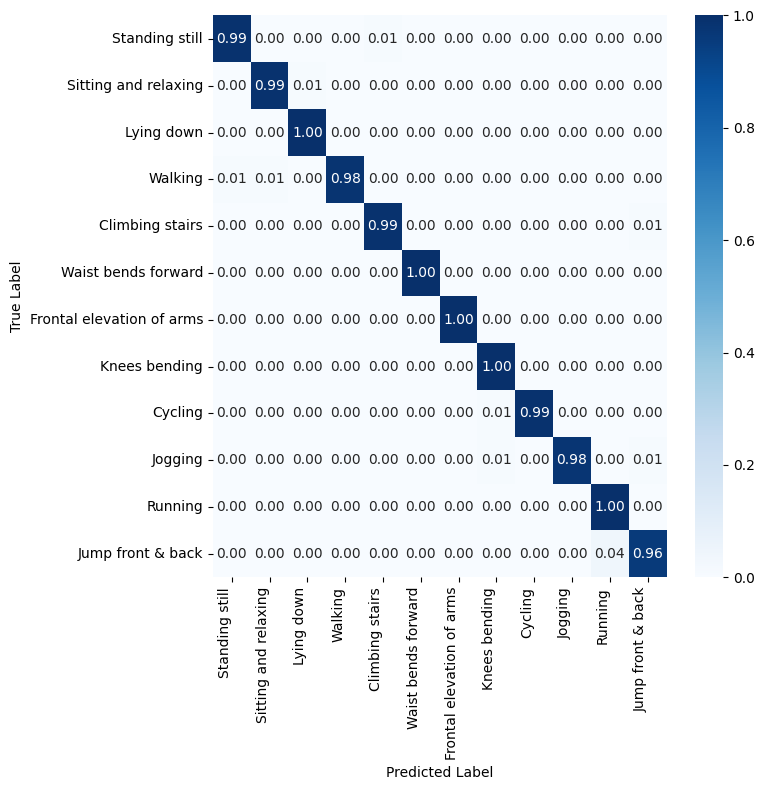


Generating t-SNE visualization (MODEL FEATURE)...


Extracting features for t-SNE: 100%|██████████| 9/9 [00:00<00:00, 176.56it/s]


[Saved] t-SNE (feature space) → tsne_feature.png


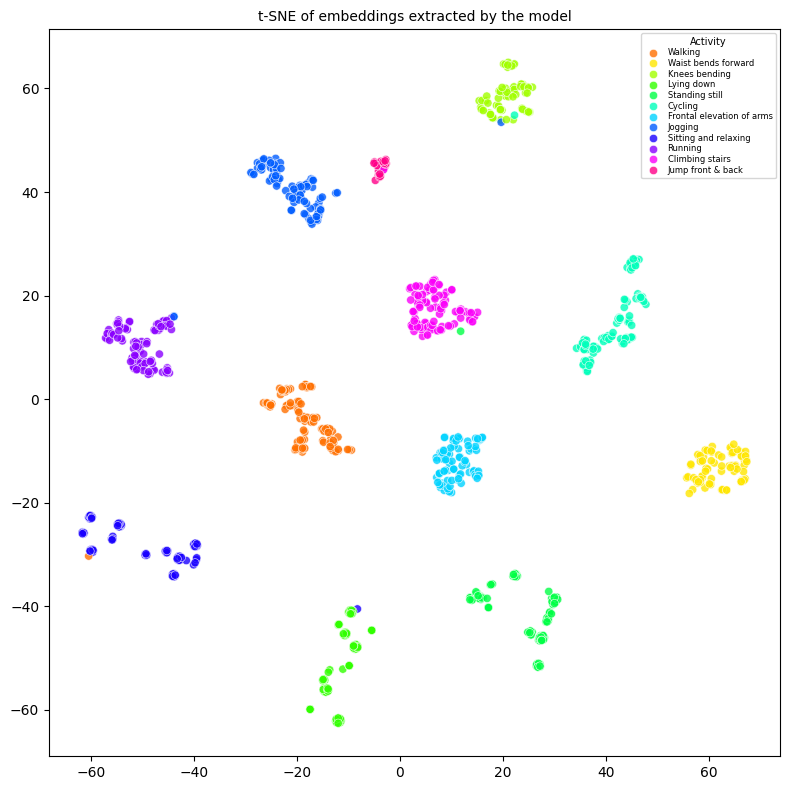


Generating t-SNE visualization (RAW INPUT)...


[Saved] t-SNE (raw input) → tsne_raw.png


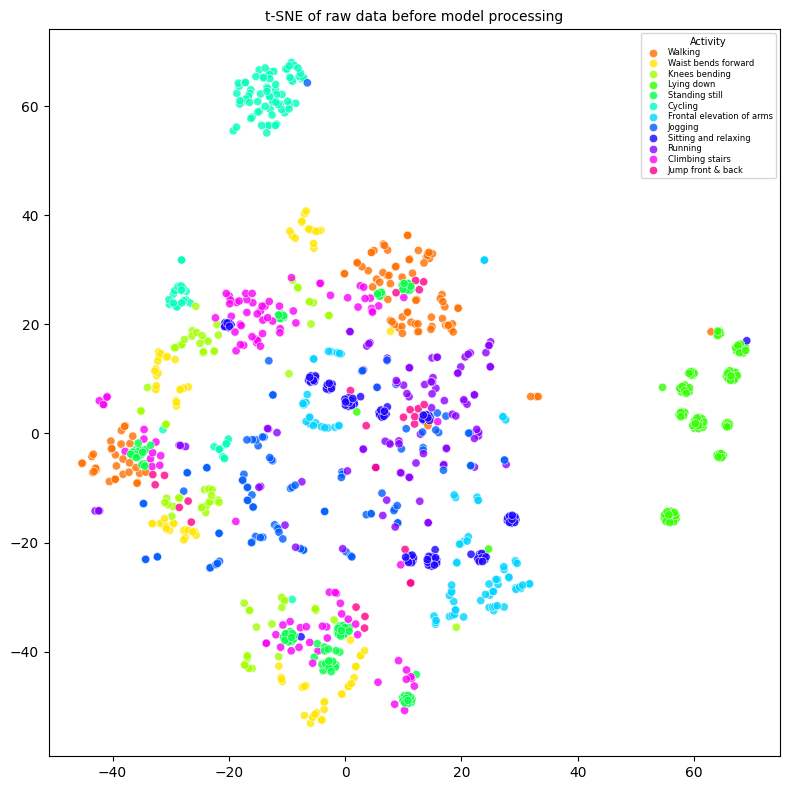

ALL PROCESSES COMPLETED!


In [13]:
# =====================================================================
# 10. Main (MHEALTH, UCI-HAR 스타일)
# =====================================================================
def main():
    # -----------------------------
    # Device / SEED / Config dump
    # -----------------------------
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed_everything(CONFIG["seed"])

    print("=" * 80)
    print(f"DataSet : {CONFIG['dataset_name']}")
    print(f"Device  : {DEVICE}")
    print("=" * 80)
    pretty_print_config(CONFIG)

    # -----------------------------
    # 1) 로우 데이터 로드 (윈도우링 포함)
    #    MHEALTHDataset:
    #      - 모든 subject 로그 concat
    #      - label 0 제거 및 (1..12 -> 0..11) shift
    #      - 슬라이딩 윈도우 (window_size, step_size)
    #      - 각 윈도우 라벨 = 마지막 프레임 라벨
    # -----------------------------
    full_dataset = MHEALTHDataset(
        data_dir=CONFIG["data_dir"],
        window_size=CONFIG["window_size"],
        step_size=CONFIG["step_size"],
    )

    # 라벨 이름 저장 (시각화용)
    label_names = full_dataset.label_names  # length == n_classes (12)

    # -----------------------------
    # 2) Train / Val / Test split
    #    - random split 비율: 60 / 20 / 20
    #    (subject-wise split은 아직 dataset에 subject id가 없으니 여기선 random 기준)
    # -----------------------------
    total_size = len(full_dataset)
    train_size = int(0.6 * total_size)
    val_size   = int(0.2 * total_size)
    test_size  = total_size - train_size - val_size

    train_subset, val_subset, test_subset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(CONFIG["seed"])
    )

    # -----------------------------
    # 3) Standardization (per-channel)
    #    - train subset 기준으로 StandardScaler fit
    #    - (N,C,T) -> (N*T, C) reshape 해서 채널별 평균0/분산1
    #    - 변환 뒤 다시 (N,C,T)
    # -----------------------------
    def subset_to_numpy(subset):
        X_list = []
        y_list = []
        for x_i, y_i in subset:
            X_list.append(x_i.numpy())      # (C,T)
            y_list.append(int(y_i.item()))
        X_np = np.stack(X_list, axis=0)     # (N,C,T)
        y_np = np.array(y_list, dtype=np.int64)  # (N,)
        return X_np, y_np

    X_train_raw, y_train = subset_to_numpy(train_subset)
    X_val_raw,   y_val   = subset_to_numpy(val_subset)
    X_test_raw,  y_test  = subset_to_numpy(test_subset)

    C_in = CONFIG["in_channels"]
    T_len = CONFIG["seq_len"]  # should match CONFIG["window_size"] (=128)

    assert X_train_raw.shape[1] == C_in,  "Channel dim mismatch"
    assert X_train_raw.shape[2] == T_len, "Seq len mismatch"

    scaler = StandardScaler()

    # fit on train
    X_train_reshaped = X_train_raw.transpose(0, 2, 1).reshape(-1, C_in)  # (N*T, C)
    scaler.fit(X_train_reshaped)

    # transform all splits
    def apply_scaler(X_raw):
        X_rs   = X_raw.transpose(0, 2, 1).reshape(-1, C_in)      # (N*T,C)
        X_norm = scaler.transform(X_rs)                          # scaled
        X_out  = X_norm.reshape(-1, T_len, C_in).transpose(0, 2, 1)  # (N,C,T)
        return X_out.astype(np.float32)

    X_train = apply_scaler(X_train_raw)
    X_val   = apply_scaler(X_val_raw)
    X_test  = apply_scaler(X_test_raw)

    # TensorDatasets 최종 버전
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).long()
    )
    val_dataset = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(y_val).long()
    )
    test_dataset = TensorDataset(
        torch.from_numpy(X_test).float(),
        torch.from_numpy(y_test).long()
    )

    # 프로토타입 초기화용으로는 "train 전체" 텐서데이터셋을 그대로 넘길 거라서
    train_full_dataset = train_dataset

    print("=" * 80)
    print(f"Split sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")
    print("=" * 80)

    # -----------------------------
    # 4) DataLoader들 (seed 고정, worker_init_fn 고정)
    # -----------------------------
    g = torch.Generator().manual_seed(CONFIG["seed"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    # -----------------------------
    # 5) Prototype 초기화 (class mean features)
    #    - get_mean_prototypes()는 working_dim 기준으로
    #      클래스별 평균 feature 뽑아서 (n_classes, dim) 반환
    # -----------------------------
    initial_prototypes = get_mean_prototypes(
        train_full_dataset,
        DEVICE,
        CONFIG
    )

    # -----------------------------
    # 6) 모델 생성
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels        = CONFIG["in_channels"],
        seq_len            = CONFIG["seq_len"],
        embed_dim          = CONFIG["embed_dim"],
        reduced_dim        = CONFIG["reduced_dim"],
        n_classes          = CONFIG["n_classes"],
        n_prototypes       = CONFIG["n_prototypes"],
        n_heads            = CONFIG["n_heads"],
        kernel_size        = CONFIG["kernel_size"],
        dropout            = CONFIG["dropout"],
        temperature        = CONFIG["temperature"],
        initial_prototypes = initial_prototypes,    # mean proto init
        use_cbam           = CONFIG["use_cbam"],
        use_crossformer    = CONFIG["use_crossformer"],
        use_contrast       = CONFIG["use_contrast"],
        use_dim_reduction  = CONFIG["use_dim_reduction"],
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")
    print("=" * 80)

    # -----------------------------
    # 7) Optimizer / Scheduler / Criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["scheduler_T_max"],
    )

    # -----------------------------
    # 8) Train Loop
    # -----------------------------
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    history = []

    for epoch in range(CONFIG["epochs"]):
        # ---- train
        train_total, train_ce, train_ct, train_acc, train_f1 = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # ---- val
        val_total, val_acc, val_f1, _, _, val_ce, val_ct = evaluate(
            model,
            val_loader,
            criterion,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # ---- scheduler
        if scheduler is not None:
            scheduler.step()

        # ---- log history
        history.append({
            "epoch": epoch + 1,
            "train_total": train_total,
            "train_ce": train_ce,
            "train_ct": train_ct,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_total": val_total,
            "val_ce": val_ce,
            "val_ct": val_ct,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # ---- best ckpt (val_acc 기준)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        # ---- periodic print
        if (epoch + 1) % CONFIG["print_every"] == 0:
            ep_now   = epoch + 1
            ep_total = CONFIG["epochs"]
            print(f"[{ep_now:03d}/{ep_total:03d}]")
            print(
                "  train | "
                f"total={train_total:.4f}  "
                f"ce={train_ce:.4f}  "
                f"ct={train_ct:.4f}  "
                f"acc={train_acc:.4f}  "
                f"f1={train_f1:.4f}"
            )
            print(
                "  val   | "
                f"total={val_total:.4f}  "
                f"ce={val_ce:.4f}  "
                f"ct={val_ct:.4f}  "
                f"acc={val_acc:.4f}  "
                f"f1={val_f1:.4f}"
            )

    # -----------------------------
    # 9) Load Best ckpt & Final Test
    # -----------------------------
    assert best_state is not None, "Training loop didn't save any best_state."
    model.load_state_dict(best_state)

    test_total, test_acc, test_f1, test_preds, test_labels, test_ce, test_ct = evaluate(
        model,
        test_loader,
        criterion,
        DEVICE,
        use_contrast=CONFIG["use_contrast"],
        contrast_weight=CONFIG["contrast_weight"],
    )

    print("=" * 80)
    print("\n[Training Complete!]")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(
        f"  Test (best val ckpt): "
        f"acc={test_acc:.4f}, f1={test_f1:.4f}, "
        f"total_loss={test_total:.4f}, ce={test_ce:.4f}, ct={test_ct:.4f}"
    )

    # -----------------------------
    # 10) Model profile (params / FLOPs / time)
    # -----------------------------
    if CONFIG["profile_model"]:
        dummy_input = torch.randn(
            1,
            CONFIG["in_channels"],
            CONFIG["seq_len"],
        )
        stats = profile_model(model, dummy_input, DEVICE)
        print("==== Model Profile ====")
        print(f"Parameters      : {stats['params_m']:.4f} M")
        print(f"FLOPs / sample : {stats['flops_m']}")
        print(f"Infer Time     : {stats['inference_ms']:.2f} ms/sample")
        print("=======================")

    # -----------------------------
    # 11) Visualizations (ConfMat / t-SNEs)
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        label_names=label_names,
        save_path="confusion_matrix.png",
    )

    if CONFIG["do_tsne"]:
        visualize_tsne(
            model,
            test_loader,
            DEVICE,
            label_names=label_names,
            save_path="tsne_feature.png",
        )

        visualize_tsne_raw(
            test_loader,
            DEVICE,
            label_names=label_names,
            save_path="tsne_raw.png",
        )

    print("=" * 80)
    print("ALL PROCESSES COMPLETED!")
    print("=" * 80)


if __name__ == "__main__":
    main()
